In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse
from scipy.sparse.linalg import svds

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import matplotlib.pyplot as plt

In [2]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))

In [16]:
ratings = pd.read_csv('ml-100k/udata.csv', header=0, sep=';', encoding='latin-1', engine='python', names=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('ml-100k/uuser.csv', header=0, sep=';', encoding='latin-1', engine='python', names=['user_id', 'age', 'gender','occupation', 'zipcode'])

In [19]:
ratings['user_id'] = ratings['user_id'] - 1
ratings['movie_id'] = ratings['movie_id'] - 1
users['user_id'] = users['user_id'] - 1

In [21]:
f_users = users[users['gender'] == 'F']
m_users = users[users['gender'] == 'M']
print('Number of female users: {}\nNumber of male users: {}'.format(f_users.shape[0], m_users.shape[0]))

Number of female users: 273
Number of male users: 670


In [36]:
def df_to_mat(df, item_n, user_n, user_id_to_iid):
    """
    Convert DataFrame to sparse matrix.

    Arg:
        df: DataFrame, ratings dataframe with user_id, movie_id and rating

    Return:
        mat: scipy.sparse.csr_matrix, sparse ratings matrix with rows being userss and cols being items
    """
    
    mat = sparse.lil_matrix((user_n, item_n))
    for _, row in df.iterrows():
        user_id = int(row[0])
        item_id = int(row[1])
        user_iid = user_id_to_iid[user_id]
        item_iid = item_id
        rating = row[2]
        mat[user_iid, item_iid] = rating
    
    return mat 

In [31]:
def cf_recommend(user_id, topk, user_id_to_iid, known_rating_mat, est_rating_mat):
    
    user_iid = user_id_to_iid[user_id]
    user_ratings = known_rating_mat[user_iid, :]
    rated_before = np.nonzero(user_ratings)[1]
    estimations = est_rating_mat[user_iid, :].copy()
    estimations[rated_before] = 0

    top_item_ids = np.argsort(-estimations)[:topk]

    return (user_id, np.array(top_item_ids))

In [25]:
# find the top 50 most popular movies
top_movie_ids = ratings.movie_id.value_counts().iloc[:50].index.to_numpy()
top_movie_ids.sort()
top_movie_ids

array([  0,   6,   8,  14,  21,  24,  27,  49,  55,  63,  68,  78,  95,
        97,  99, 116, 117, 120, 126, 150, 167, 171, 172, 173, 175, 180,
       182, 194, 201, 203, 209, 215, 221, 233, 236, 256, 257, 268, 275,
       285, 287, 293, 299, 301, 312, 317, 327, 404, 422, 747], dtype=int64)

In [47]:
# randomly sample 200 female users for experiment, fixed
f_user_ids = f_users.sample(200)['user_id'].to_numpy()

In [57]:
# for each of the 200 sampled female user, randomly select 2 movies (in the top 50) for testing
test_movie_ids = {}
for id in f_user_ids:
    rated_movie_ids = ratings[ratings['user_id'] == id]['movie_id'].to_numpy()
    rated_top_movie_ids = [i for i in rated_movie_ids if i in top_movie_ids]
    if len(rated_top_movie_ids) < 2:
        continue 
    else:
        test_movies = random.sample(rated_top_movie_ids, 2)
        test_movie_ids[id] = test_movies

In [60]:
# get the female users' ratings for top 50 movies
f_top_ratings = ratings[ratings.user_id.isin(f_user_ids) & ratings.movie_id.isin(top_movie_ids)]

In [61]:
f_real_top_ratings = f_top_ratings.groupby('movie_id')['rating'].mean()

In [67]:
n_male = 200
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = ratings['movie_id'].nunique()

test_df = []
train_df = []
for _, row in sampled_ratings.iterrows():
    user_id = row[0]
    movie_id = row[1]
    if user_id not in f_user_ids:
        train_df.append(row)
    else:
        if movie_id in test_movie_ids[user_id]:
            test_df.append(row)
        else:
            train_df.append(row)
test_df = pd.DataFrame(test_df)
train_df = pd.DataFrame(train_df)

known_rating_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid)

mf = TruncatedSVD(n_components=100, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id

    est = est_rating_mat[user_iid, movie_iid]
    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_1 = test_df.groupby('movie_id')['est'].mean()

In [70]:
f_est_top_ratings_1

movie_id
0      0.470968
8      0.126318
14     0.274733
49     1.051776
99     0.200037
117    0.581891
120    0.787269
180    0.630663
236    0.716875
256    0.496458
268    0.154312
285    0.588584
299    0.962110
Name: est, dtype: float64

In [45]:
est_rating_mat[2,0]

4.54547969786116

In [46]:
known_rating_mat[2,0]

4.0

In [40]:
n_male = 100
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = ratings['movie_id'].nunique()

test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]

known_rating_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid)

mf = TruncatedSVD(n_components=100, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id

    est = est_rating_mat[user_iid, movie_iid]
    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_2 = test_df.groupby('movie_id')['est'].mean()

C:\Users\sky_l\AppData\Local\Temp\ipykernel_14332\4145647758.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['est'] = np.array(est_ratings)


In [41]:
n_male = 400
m_user_ids = m_users.sample(n_male)['user_id'].to_numpy()

sampled_ratings = ratings[(ratings['user_id'].isin(f_user_ids)) | (ratings['user_id'].isin(m_user_ids))]
sampled_user_ids = sampled_ratings['user_id'].unique()
user_id_to_iid = {sampled_user_ids[i]:i for i in range(len(sampled_user_ids))}
user_iid_to_id = {i:sampled_user_ids[i] for i in range(len(sampled_user_ids))}

user_n = sampled_ratings['user_id'].nunique()
item_n = ratings['movie_id'].nunique()

test_df = sampled_ratings[(sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids))]
train_df = sampled_ratings[~((sampled_ratings['movie_id'].isin(top_movie_ids)) & (sampled_ratings['user_id'].isin(f_user_ids)))]

known_rating_mat = df_to_mat(train_df, item_n, user_n, user_id_to_iid)

mf = TruncatedSVD(n_components=100, algorithm='arpack', tol=0.0)
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

est_ratings = []
for _, row in test_df.iterrows():
    user_id = row[0]
    movie_id = row[1]

    user_iid = user_id_to_iid[user_id]
    movie_iid = movie_id

    est = est_rating_mat[user_iid, movie_iid]
    est_ratings.append(est)
test_df['est'] = np.array(est_ratings)

f_est_top_ratings_3 = test_df.groupby('movie_id')['est'].mean()

C:\Users\sky_l\AppData\Local\Temp\ipykernel_14332\3483117660.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['est'] = np.array(est_ratings)


ValueError: x and y must be the same size

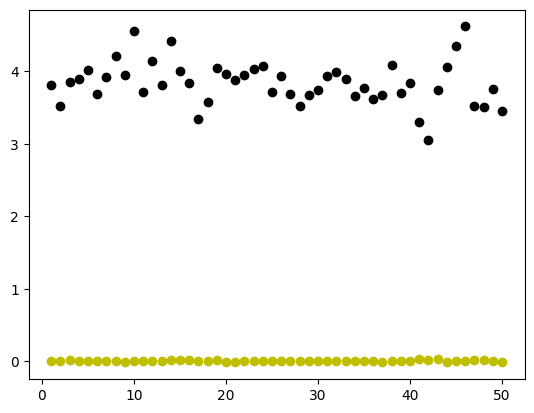

In [69]:
fig, ax = plt.subplots()
ax.scatter(np.arange(50)+1, f_real_top_ratings, c='k', label='True average rating')
ax.scatter(np.arange(50)+1, f_est_top_ratings_2, c='y', label='Influenced by 25 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_1, c='g', label='Influenced by 100 male')
ax.scatter(np.arange(50)+1, f_est_top_ratings_3, c='m', label='Influenced by 400 male')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,50])
ax.set_ylim([0,6])
ax.set_xlabel('Top 50 movies')
ax.set_ylabel('Rating')
plt.title('The influence of number of male users on the female rating estimations')
plt.show()